### OOD Data Generation Pipeline

Grounding DINO creates Detection Mask --> SAM creates segmentation Mask --> Flux Creates Mask

Flux Inpaintings do work much worse with black-forest-labs/FLUX.1-dev than with black-forest-labs/FLUX.1-Fill-dev

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, SamProcessor, SamModel
import torch
import numpy as np
from PIL import Image, ImageDraw
from diffusers import FluxInpaintPipeline
import requests
from io import BytesIO
import os
from GroundingDINO.groundingdino.util.inference import load_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Grounding DINO
print("Loading Grounding DINO...")
processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
grounding_model = AutoModelForZeroShotObjectDetection.from_pretrained(
    "IDEA-Research/grounding-dino-base"
).to(device)

# Load SAM
sam_model_id = "facebook/sam-vit-huge" 
print(f"Loading SAM model: {sam_model_id}")
sam_processor = SamProcessor.from_pretrained(sam_model_id)
sam_model = SamModel.from_pretrained(sam_model_id).to(device)

# Load Flux Inpainting Pipeline
print("Loading Flux inpainting pipeline...")
flux_pipeline = FluxInpaintPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev", # Problem might be that we are not using "fill-dev", fill version!
    # "black-forest-labs/FLUX.1-schnell",
    torch_dtype=torch.bfloat16
).to(device)

def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)
    output_dir = os.path.dirname(image_file_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

In [ ]:
local_image_path = "assets/inpaint_demo.jpg"
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
download_image(image_url, local_image_path)
# image_source, image = load_image(local_image_path) # ((512, 512, 3), torch.Size([3, 800, 800]))
image = Image.open(local_image_path)
image_source = np.array(image)
Image.fromarray(image_source)

In [3]:
def detect_with_transformers(image, text_prompt, threshold=0.3, text_threshold=0.25):
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = grounding_model(**inputs)
    
    results = processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, box_threshold=threshold, text_threshold=text_threshold, target_sizes=[image.shape[:2]]
    )[0]
    
    boxes_xyxy = results["boxes"]  # These are already in xyxy format, unnormalized
    return boxes_xyxy.cpu() if boxes_xyxy.numel() > 0 else torch.empty(0, 4)

def segment_with_transformers(image_np, sam_processor, sam_model, detected_boxes):
    """Fixed version that returns both masks and iou_scores with correct shapes"""
    H_orig, W_orig = image_np.shape[:2]
    
    if detected_boxes.numel() > 0:
        input_boxes_for_processor = [detected_boxes.tolist()] 
    else:
        input_boxes_for_processor = [torch.empty(0, 4).tolist()]
    
    inputs = sam_processor(image_np, input_boxes=input_boxes_for_processor, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = sam_model(**inputs)
    
    iou_scores = outputs.iou_scores
    masks = sam_processor.post_process_masks(
        outputs.pred_masks, 
        inputs.original_sizes,
        inputs.reshaped_input_sizes
    )
    
    # masks is a list, convert to tensor and ensure correct shape
    if isinstance(masks, list) and len(masks) > 0:
        masks = masks[0]  # Take first batch
    
    # Debug: print actual shapes
    print(f"Raw masks shape: {masks.shape}")
    print(f"Raw iou_scores shape: {iou_scores.shape}")
    
    # Ensure masks has shape [batch, num_detections, num_candidates, H, W]
    if masks.ndim == 4:  # [batch, num_candidates, H, W] - missing detection dim
        masks = masks.unsqueeze(1)  # Add detection dimension -> [batch, 1, num_candidates, H, W]
        print(f"Added detection dimension: {masks.shape}")
    
    if masks.numel() > 0:
        return masks.cpu(), iou_scores.cpu()
    else:
        return torch.empty(0, 0, 3, H_orig, W_orig), torch.empty(0, 0, 3)

In [12]:
def apply_inpainting(image, mask, prompt, negative_prompt="blurry, low quality", num_inference_steps=28, guidance_scale=3.5):
    """
    Apply Flux inpainting to an image with a mask
    
    Args:
        image: PIL Image or numpy array
        mask: torch.Tensor or numpy array (H, W) - binary mask where 1 = inpaint
        prompt: str - text prompt for inpainting
        negative_prompt: str - negative prompt
        num_inference_steps: int - number of denoising steps
        guidance_scale: float - guidance scale
    
    Returns:
        PIL Image - inpainted result
    """
    # Convert inputs to PIL Images
    if isinstance(image, np.ndarray):
        image_pil = Image.fromarray(image)
    else:
        image_pil = image
    
    # Convert mask to PIL Image
    if torch.is_tensor(mask):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = mask
    
    # Ensure mask is binary and convert to PIL
    mask_np = (mask_np > 0.5).astype(np.uint8) * 255
    mask_pil = Image.fromarray(mask_np).convert("L")
    
    # Apply inpainting
    result = flux_pipeline(
        prompt=prompt,
        image=image_pil,
        mask_image=mask_pil,
        num_inference_steps=num_inference_steps,
        # guidance_scale=guidance_scale,
        # negative_prompt=negative_prompt
    ).images[0]
    
    return result

In [5]:
def draw_mask(masks, image_np, detected_boxes=None, draw_boxes=True, random_color=True):
    """Draw multiple segmentation masks and optionally bounding boxes"""
    result_image = image_np.copy()
    result_pil = Image.fromarray(result_image).convert("RGBA")
    colors = []
    
    # Handle different mask input shapes
    if torch.is_tensor(masks):
        masks_np = masks.cpu().numpy()
    else:
        masks_np = masks
    
    # Ensure masks is at least 3D [num_masks, H, W]
    if masks_np.ndim == 2:
        masks_np = masks_np[None, ...]  # Add batch dimension
    elif masks_np.ndim == 4:
        masks_np = masks_np.squeeze()  # Remove extra dimensions
        
    # Get target image dimensions
    target_h, target_w = image_np.shape[:2]
    
    # Draw each mask
    for i in range(masks_np.shape[0]):
        mask = masks_np[i].astype(np.float32)
        
        # Ensure mask is 2D
        if mask.ndim != 2:
            mask = mask.squeeze()
            if mask.ndim != 2:
                # Try to reshape to square if possible
                total_pixels = mask.size
                side_length = int(np.sqrt(total_pixels))
                if side_length * side_length == total_pixels:
                    mask = mask.reshape(side_length, side_length)
                else:
                    print(f"Error: Cannot reshape mask with {total_pixels} pixels to 2D")
                    continue
        
        # Resize mask to match image if needed
        mask_h, mask_w = mask.shape
        if mask_h != target_h or mask_w != target_w:
            mask_pil_temp = Image.fromarray((mask * 255).astype(np.uint8))
            mask_pil_temp = mask_pil_temp.resize((target_w, target_h), Image.LANCZOS)
            mask = np.array(mask_pil_temp).astype(np.float32) / 255.0
        
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            predefined_colors = [
                [1.0, 0.0, 0.0, 0.6],  # Red
                [0.0, 1.0, 0.0, 0.6],  # Green
                [0.0, 0.0, 1.0, 0.6],  # Blue
                [1.0, 1.0, 0.0, 0.6],  # Yellow
                [1.0, 0.0, 1.0, 0.6],  # Magenta
                [0.0, 1.0, 1.0, 0.6],  # Cyan
            ]
            color = np.array(predefined_colors[i % len(predefined_colors)])
        
        colors.append(color)
        
        # Create colored mask
        h, w = mask.shape
        mask_colored = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        mask_pil = Image.fromarray((mask_colored * 255).astype(np.uint8)).convert("RGBA")
        
        # Ensure both images have the same size
        if mask_pil.size != result_pil.size:
            print(f"Debug: Resizing mask_pil from {mask_pil.size} to {result_pil.size}")
            mask_pil = mask_pil.resize(result_pil.size, Image.LANCZOS)
        
        # Alpha composite
        result_pil = Image.alpha_composite(result_pil, mask_pil)
    
    # Draw bounding boxes if provided
    if detected_boxes is not None and draw_boxes:
        result_pil = result_pil.convert("RGB")
        draw = ImageDraw.Draw(result_pil)
        
        boxes_np = detected_boxes.cpu().numpy() if torch.is_tensor(detected_boxes) else detected_boxes
        
        for i in range(min(len(boxes_np), len(colors))):
            x1, y1, x2, y2 = boxes_np[i]
            box_color = tuple((colors[i][:3] * 255).astype(int))
            draw.rectangle([x1, y1, x2, y2], outline=box_color, width=3)
        
        result_pil = result_pil.convert("RGBA")
    
    return np.array(result_pil.convert("RGB"))

Image downloaded from url: https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png and saved to: assets/inpaint_demo.jpg.
1. Detecting objects...
Detected 3 objects
2. Segmenting objects...
Raw masks shape: torch.Size([3, 3, 512, 512])
Raw iou_scores shape: torch.Size([1, 3, 3])
Added detection dimension: torch.Size([3, 1, 3, 512, 512])
3. Selecting best masks...
4. Visualizing detection and segmentation...


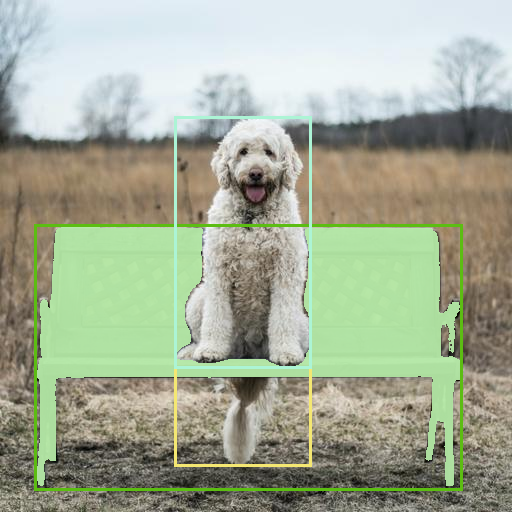

5. Applying inpainting...


In [6]:
local_image_path = "assets/inpaint_demo.jpg"
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
download_image(image_url, local_image_path)

# Load image
from GroundingDINO.groundingdino.util.inference import load_image
image_source, image = load_image(local_image_path)

# Define what to detect and inpaint
detection_prompt = "a white, fluffy dog"
inpaint_prompt = "a red brick wall"

print("1. Detecting objects...")
detected_boxes = detect_with_transformers(image_source, detection_prompt, threshold=0.15, text_threshold=0.3)
print(f"Detected {len(detected_boxes)} objects")

if len(detected_boxes) > 0:
    print("2. Segmenting objects...")
    masks, iou_scores = segment_with_transformers(image_source, sam_processor, sam_model, detected_boxes)
    print("3. Selecting best masks...")
    best_mask_indices = iou_scores.argmax(dim=-1)
    batch_indices = torch.arange(masks.shape[0])[:, None]
    box_indices = torch.arange(masks.shape[1])[None, :]
    best_masks = masks[batch_indices, box_indices, best_mask_indices]
    print("4. Visualizing detection and segmentation...")
    annotated_frame = draw_mask(best_masks[0], image_source, detected_boxes, draw_boxes=True, random_color=True)
    display(Image.fromarray(annotated_frame))
    
    print("5. Applying inpainting...")
else:
    print("No objects detected!")

In [ ]:
first_mask = best_masks[1, 0]  # Shape: [H, W]

Image.fromarray(first_mask.numpy())

In [ ]:
inpainted_result = apply_inpainting(
    image_source, 
    first_mask, 
    inpaint_prompt,
    num_inference_steps=100,
    # guidance_scale=50
)

print("6. Showing inpainting result...")
display(inpainted_result)

### Flux Fill

In [2]:
import torch
from diffusers import FluxFillPipeline
from diffusers.utils import load_image

# image = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/cup.png")
# mask = load_image("https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/cup_mask.png")

repo_id = "black-forest-labs/FLUX.1-Fill-dev"
pipe = FluxFillPipeline.from_pretrained(repo_id, torch_dtype=torch.bfloat16).to("cuda")

# image = pipe(
#     prompt="a white paper cup",
#     image=image,
#     mask_image=mask,
#     height=512,
#     width=512,
#     max_sequence_length=512,
#     generator=torch.Generator("cpu").manual_seed(0)
# ).images[0]

2025-07-27 16:18:34.064256: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 16:18:35.724893: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 16:18:36.784653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 16:18:36.785298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 16:18:36.994840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Dataset

In [6]:
import pickle
from PIL import Image

# with open('data/fractal_diffusion_dataset_traj100.pkl', 'rb') as f:
#     data = pickle.load(f)
with open('data/bridge_v0.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
from utils.ood_utils import create_inpaintings_from_mask

create_inpaintings_from_mask(data, pipe, save_path='data/bridge_v0_inpainted.pkl')

In [ ]:
from utils.plot_utils import plot_inpainting_results

with open('data/bridge_v0_inpainted.pkl', 'rb') as f:
    data = pickle.load(f)
plot_inpainting_results(data, samples_per_category=20)

In [5]:
# plot_inpainting_results(data, samples_per_category=20, save_path="plots/inpainted_bridge_traj_27-07")

In [ ]:
# then also add OOD score (and clip/muse...)

### Evaluate Ensemble on OOD data

#### Debugging

In [97]:
# Image.fromarray(data['trajectories'][0]['first_mask'])
idx = 1
i1 = data['trajectories'][idx]['first_image']
m1 = data['trajectories'][idx]['first_mask']
print(data['trajectories'][idx].keys())
print(data['trajectories'][idx]['language'])
print(data['trajectories'][idx]['inpainting_prompt'])
inpaint_prompt = data['trajectories'][idx]['inpainting_prompt']
i1.shape, m1.shape

dict_keys(['first_image', 'last_image', 'first_action', 'last_action', 'first_next_action', 'last_next_action', 'language', 'dataset', 'traj_length', 'trajectory_id', 'action', 'first_mask', 'last_mask', 'inpainting_prompt', 'ood_category'])
close microwave
A seamless continuation of the wall in the background, naturally blending with the surrounding background


((256, 256, 3), (256, 256))

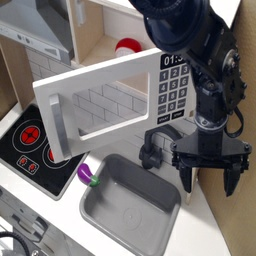

In [98]:
Image.fromarray(i1)

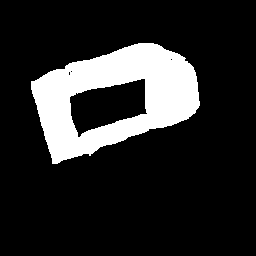

In [99]:
Image.fromarray(m1)

  0%|          | 0/50 [00:00<?, ?it/s]

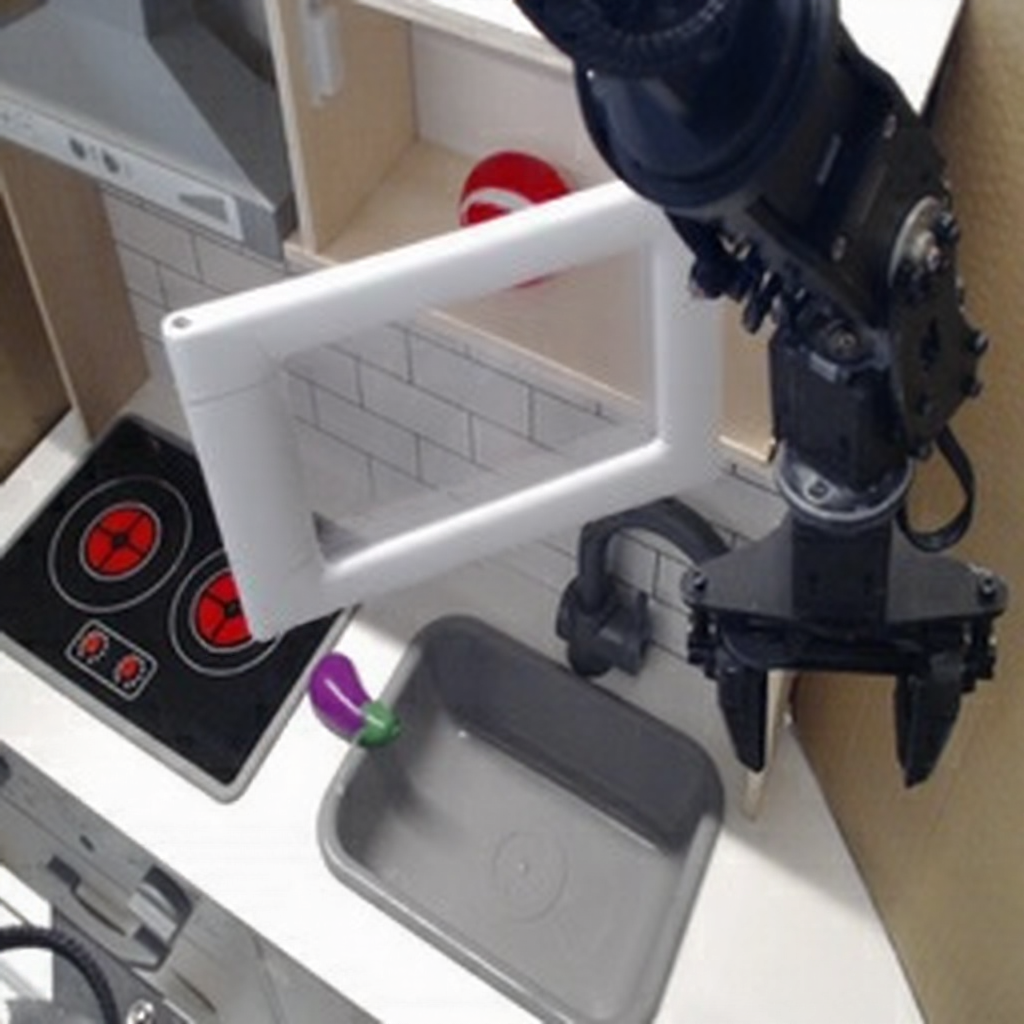

In [100]:
image = pipe(
    prompt=inpaint_prompt,#inpaint_prompt
    image=Image.fromarray(i1),
    mask_image=Image.fromarray(m1),
    height=1024, # output res has to be divisible by 16
    width=1024,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image

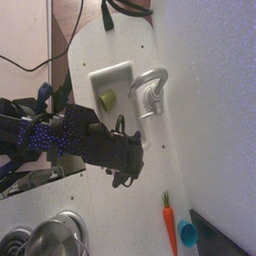

In [36]:
image.resize((256,256), Image.Resampling.BICUBIC)
